<a href="https://colab.research.google.com/github/limestonestreams/thesis/blob/master/Sentence_classification_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

From https://realpython.com/python-keras-text-classification/

Importing the data:

In [107]:
# reading excel file
import pandas
label_data = pandas.read_excel (r'https://github.com/limestonestreams/thesis/blob/master/label_data.xlsx?raw=true', sheet_name = 'Sheet1')

# turning into pandas dataframe
df = pandas.DataFrame(label_data)

print(df.iloc[0])

doc_id                                            text13066.1
text        The Kingdom of the Netherlands stands firmly  ...
filename                       UNSC_2018_SPV.8250_spch015.txt
year                                                     2018
country                                           Netherlands
topic                                  Libyan Arab Jamahiriya
title              Netherlands on Libyan Arab Jamahiriya 2018
date                                               9 May 2018
class                                              irrelevant
Name: 0, dtype: object


Changing labels column to numeric for input into keras model:

In [108]:
df.dtypes
print(df['class'].value_counts())
df["class"] = df["class"].astype('category')
df["class"] = df["class"].cat.codes
print(df["class"].value_counts())

# 0 - against
# 1 - delegitimizing
# 2 - for
# 3 - humanizing
# 4 - irrelevant
# 5 - legitimizing

irrelevant        728
for                84
against            77
legitimizing       46
delegitimizing     45
humanizing         20
Name: class, dtype: int64
4    728
2     84
0     77
5     46
1     45
3     20
Name: class, dtype: int64


Re-coding non-irrelevant categories to relevant:

In [109]:
df.loc[df['class'] != 4, 'class'] = 1
df.loc[df['class'] == 4, 'class'] = 0
print(df["class"].value_counts())

0    728
1    272
Name: class, dtype: int64


Splitting into training and testing set:

In [110]:
from sklearn.model_selection import train_test_split

sentences = df['text'].values
y = df['class'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size = 0.2, random_state = 1000)

from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sentences_train[2])
print(X_train[2])

EULEX has established good cooperation with the authorities in Belgrade and Tirana.
[816, 21, 234, 334, 191, 13, 1, 166, 5, 817, 4, 1626]


Padding sentences:

In [111]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100

X_train = pad_sequences(X_train, padding = 'post', maxlen = maxlen)
X_test = pad_sequences(X_test, padding = 'post', maxlen = maxlen)

print(X_train[0, :])

[  13    7  386 1098    2  293    4  529  208    1 1099    4    1  127
 1100  530    4   69  815    5   75   50  387  454    3   30  647  127
  455   30  191    4 1101 1625   30  294    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


Keras model setup:

In [118]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

input_dim = X_train.shape[1]  # Number of features

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'sgd', metrics = ['accuracy'])

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 50)           172650    
_________________________________________________________________
flatten_5 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 10)                50010     
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 11        
Total params: 222,671
Trainable params: 222,671
Non-trainable params: 0
_________________________________________________________________


Keras model fit:

In [131]:
history = model.fit(X_train, y_train, batch_size = 5, epochs = 100, verbose = True, validation_data = (X_test, y_test))

Epoch 1/100
160/160 [==============================] - 0s 3ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 1.2438 - val_accuracy: 0.6750
Epoch 2/100
160/160 [==============================] - 0s 3ms/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 1.2700 - val_accuracy: 0.6700
Epoch 3/100
160/160 [==============================] - 0s 2ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 1.2688 - val_accuracy: 0.6700
Epoch 4/100
160/160 [==============================] - 0s 2ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 1.2896 - val_accuracy: 0.6650
Epoch 5/100
160/160 [==============================] - 0s 2ms/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 1.2922 - val_accuracy: 0.6650
Epoch 6/100
160/160 [==============================] - 0s 2ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 1.2974 - val_accuracy: 0.6650
Epoch 7/100
160/160 [==============================] - 0s 2ms/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 1.2830 - val_accuracy: 0.6700

Model evaluation:

In [132]:
loss, accuracy = model.evaluate(X_train, y_train, verbose = False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose = False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.6700


Confusion matrix:

In [133]:
# confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

pred_labels = model.predict_classes(X_test)
conf_matrix = confusion_matrix(y_test, pred_labels)
plt
print(conf_matrix)

[[124  15]
 [ 51  10]]


Plotting model evaluation:

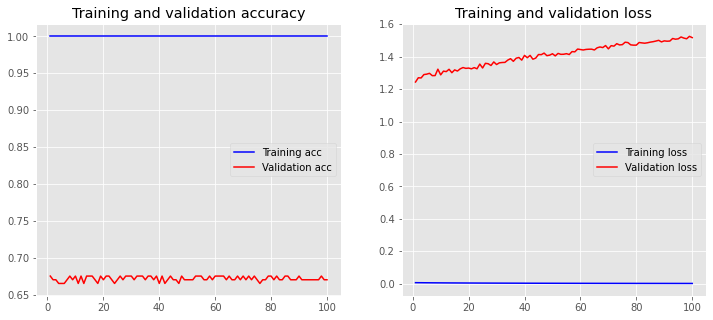

In [134]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)